In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate, Dropout
from tensorflow.keras.models import Model
import rasterio, json, os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib
import matplotlib.pyplot as plt

In [2]:
IMG_SIZE = 512

In [3]:
class Unet:
    def __init__(self,input_shape=(512, 512, 3)):
        inputs = Input(shape=input_shape)
        _tensor = inputs

        #down sampling 
        f = 8 #initially, use an 8-pixel kernel for the convolutional filter
        layers = []

        #cycle through 6 iterations, each time reusing '_tensor' 
        #on each iteration ...
        #pass through 2 convolutional blocks, append to the 'layers' output list
        #then apply max pooling, and double the filter size for the next iteration
        for i in range(0, 6):
            _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
            _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
            layers.append(_tensor)
            _tensor = MaxPooling2D() (_tensor)
            f = f*2
            print(_tensor.shape)
    
        ff2 = 64 ##use an 64-pixel kernel for the convolutional filter
 
        #bottleneck 
        j = len(layers) - 1
        _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
        _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
        _tensor = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_tensor)
        # use concatenate to merge feature maps
        _tensor = Concatenate(axis=3)([_tensor, layers[j]])
        j = j -1 
        print(_tensor.shape)   

        #upsampling 
        for i in range(0, 5):
            ff2 = ff2//2
            f = f // 2 
            _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
            _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
            _tensor = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (_tensor)
            _tensor = Concatenate(axis=3)([_tensor, layers[j]])
            j = j -1 

        _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)
        _tensor = Conv2D(f, 3, activation='relu', padding='same') (_tensor)  
        print(_tensor.shape)
        
        #classification layer
        outputs = Conv2D(1, 1, activation='sigmoid') (_tensor)
        
        #model creation
        self._model =  Model(inputs=[inputs], outputs=[outputs])
        self._model.summary()
        self._model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = [Unet.mean_iou])

    # train is a callable function of the Deep_Autoencoder class object   
    # for training the model
    def do_training(self, x_train, y_train, batch_size, num_epochs):    
        self._model.fit(x_train, # the train and validation data are the same in this case
                        x_train,
                        verbose = 1,
                        epochs = num_epochs,
                        batch_size = batch_size,
                        shuffle = True,
                        validation_split = 0.3)
        
    # returns a model prediction (a decoded image)
    def get_image(self, encoded_images):
        decoded_images = self._model.predict(encoded_images)
        return decoded_images
    
    @staticmethod
    def mean_iou(y_true, y_pred):
        yt0 = y_true[:,:,:,0] #use the 3d image, not the 4d tensor
        #binarize and make a float
        yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
        # get the intersection (numerator in above equation) 
        inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
        # get the union (denominator)
        union = tf.math.count_nonzero(tf.add(yt0, yp0))
        # compute iou as the ratio unless the denominator is zero
        iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
        return iou

In [4]:
def image_batch_generator(files, batch_size = 32, sz = (IMG_SIZE, IMG_SIZE)):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:

        #preprocess the raw images 
        rawfile = f'nwpu_images/data/{f}'
        raw = Image.open(rawfile)
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
            raw = np.stack((raw,)*3, axis=-1)

        else:
            raw = raw[:,:,0:3]
            
        #get the image dimensions, find the min dimension, then square the image off    
        nx, ny, nz = np.shape(raw)
        n = np.minimum(nx,ny)
        raw = raw[:n,:n,:] 
            
        batch_x.append(raw)
        
        #get the masks. 
        maskfile = f'nwpu_masks/data/{f}'
        mask = Image.open(maskfile)
        # the mask is 3-dimensional so get the max in each channel to flatten to 2D
        mask = np.max(np.array(mask.resize(sz)),axis=2)
        # water pixels are always greater than 100
        mask = (mask>100).astype('int')
        
        mask = mask[:n,:n]

        batch_y.append(mask.T)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255. #divide image by 255 to normalize
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

In [5]:
images = os.listdir('nwpu_images/data/')

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0,
        zoom_range=0,
        rotation_range=90,
        horizontal_flip=True)

img_generator = train_datagen.flow_from_directory(
        'nwpu_images',
        target_size=(512, 512),
        batch_size=len(images),
        class_mode=None, seed=111, shuffle=False)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,    
        shear_range=0,
        zoom_range=0,
        rotation_range=90,
        horizontal_flip=True)

mask_generator = test_datagen.flow_from_directory(
        'nwpu_masks',
        target_size=(512, 512),
        batch_size=len(images),
        class_mode=None, seed=111, shuffle=False)

Found 70 images belonging to 1 classes.
Found 70 images belonging to 1 classes.


In [6]:
train_generator = (pair for pair in zip(img_generator, mask_generator))

In [7]:
x, y = next(train_generator)

/home/daniel/anaconda3/envs/liveproject/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/daniel/anaconda3/envs/liveproject/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [8]:
np.shape(np.max(y[10], axis=2))

(512, 512)

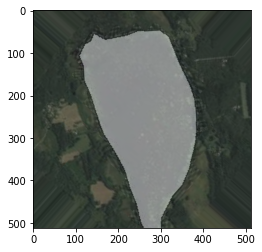

In [9]:
%matplotlib inline
plt.imshow((x[1]).astype('uint8'), cmap='gray') #show the 10th image
plt.imshow(np.max(y[1], axis=2)/255, cmap='gray', alpha=0.5) #show the 10th label as an alpha mask

In [10]:
def get_pair(i):
    img = x[i].astype('uint8')/255
    msk = np.max(y[i], axis=2)/255
    msk[msk>=.5]  = 1
    msk[msk<.5] = 0
    msk = np.stack((msk,)*3, axis=-1)
    return np.concatenate([img, msk], axis = 1)

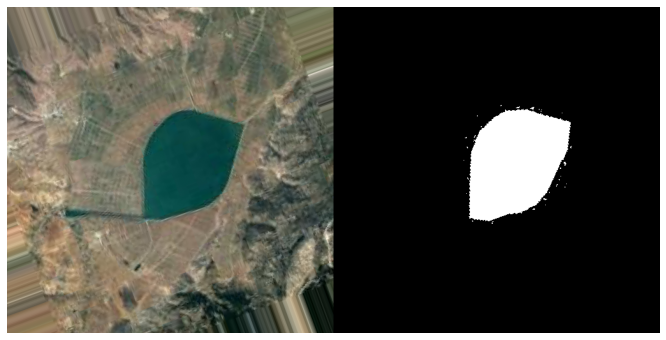

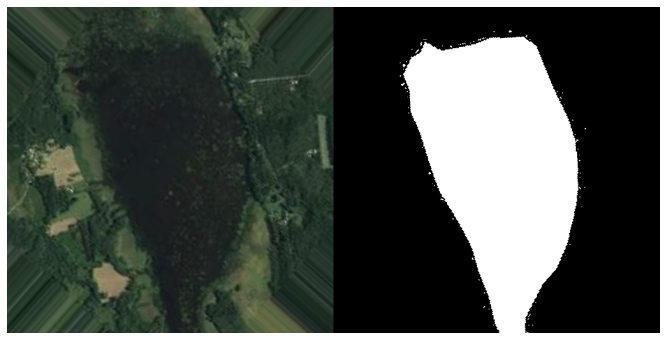

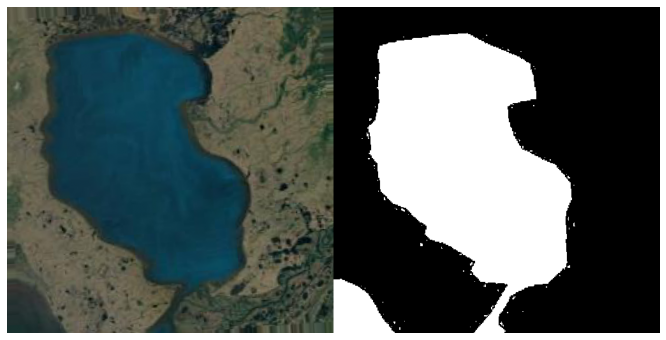

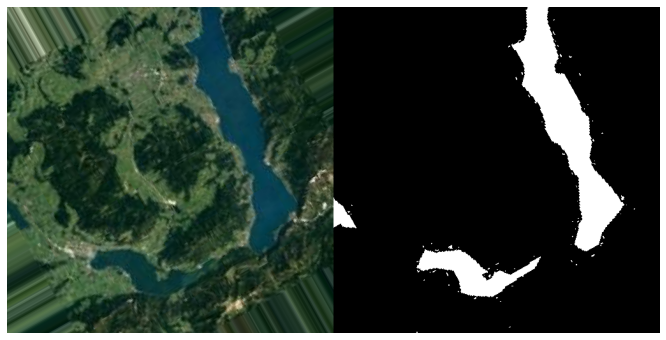

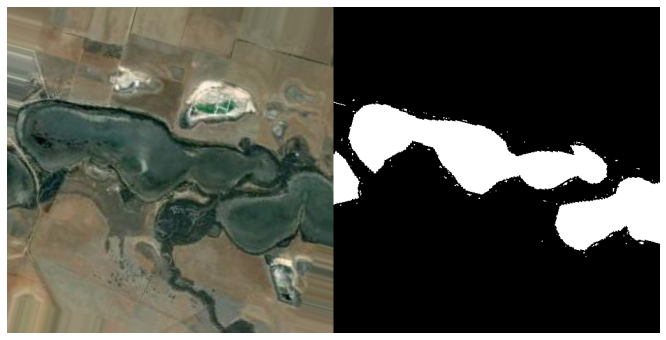

In [11]:
plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(0))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(1))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(2))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(3))

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(get_pair(4))

In [12]:
unet = Unet(input_shape=(512,512,1))

(None, 256, 256, 8)
(None, 128, 128, 16)
(None, 64, 64, 32)
(None, 32, 32, 64)
(None, 16, 16, 128)
(None, 8, 8, 256)
(None, 16, 16, 320)
(None, 512, 512, 16)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (No

In [13]:
x_train = []
y_train = []
for i in range(len(x)):
    x_val = np.squeeze(tf.image.resize(x[i], (IMG_SIZE,IMG_SIZE), method='nearest'))[:,:,0]
    x_train.append(x_val)
    msk = np.max(y[i], axis=2)/255
    msk[msk>=.5]  = 1
    msk[msk<.5] = 0
    y_train.append(msk)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), IMG_SIZE, IMG_SIZE, 1))
y_train = np.reshape(y_train, (len(y_train), IMG_SIZE, IMG_SIZE, 1))
x_test = x_train

In [14]:
unet.do_training(x_train,y_train, 8, 10)

Train on 49 samples, validate on 21 samples
Epoch 1/10
49/49 [==============================] - 26s 534ms/sample - loss: 0.6851 - mean_iou: 6.8296e-08 - val_loss: 0.6880 - val_mean_iou: 0.0000e+00
Epoch 2/10
49/49 [==============================] - 23s 465ms/sample - loss: 4.0950 - mean_iou: 0.0000e+00 - val_loss: 0.6719 - val_mean_iou: 0.0000e+00
Epoch 3/10
49/49 [==============================] - 23s 470ms/sample - loss: 0.6455 - mean_iou: 0.0000e+00 - val_loss: 0.6701 - val_mean_iou: 0.0000e+00
Epoch 4/10
49/49 [==============================] - 23s 479ms/sample - loss: 0.6482 - mean_iou: 0.0000e+00 - val_loss: 0.6668 - val_mean_iou: 0.0000e+00
Epoch 5/10
49/49 [==============================] - 24s 480ms/sample - loss: 0.6430 - mean_iou: 0.0000e+00 - val_loss: 0.6638 - val_mean_iou: 0.0000e+00
Epoch 6/10
49/49 [==============================] - 24s 499ms/sample - loss: 0.6502 - mean_iou: 0.0000e+00 - val_loss: 0.6616 - val_mean_iou: 0.0000e+00
Epoch 7/10
49/49 [====================

In [15]:
decoded_imgs = unet.get_image(x_test)

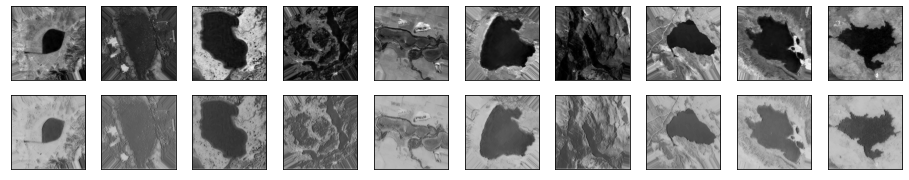

In [16]:
#create a wide (16) and short (3) figure to show 10 images
# and their autoencoded representations stacked top to bottom
plt.figure(figsize=(16, 3))
# loop through 10 sample images
for i in range(10):
    # inputs
    subplot = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(IMG_SIZE, IMG_SIZE))
    plt.gray()
    subplot.get_xaxis().set_visible(False) #turn x-axis off
    subplot.get_yaxis().set_visible(False) #turn y-axis off

    # reconstructed inputs
    subplot = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
plt.show()

In [17]:
# decoded_imgs[0]